## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
# matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [27]:
# set random seed
seed(10)
tf.random.set_seed(10)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [28]:
data = pd.read_csv('data/气化一期S4_imputed.csv')

In [29]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.index = data['timestamp']
# data = data.sort_index()

In [30]:
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (51841, 5)


,timestamp,YT.11FI_02044.PV,YT.11PIC_02044.PV,YT.11TI_02044.PV,YT.11PIC_02044.MV
timestamp,,,,,
2025-07-01 12:00:00,2025-07-01 12:00:00,30337.62695,0.457069,156.587262,NaN
2025-07-01 12:00:10,2025-07-01 12:00:10,30243.33594,0.457090,156.553284,0.0
2025-07-01 12:00:20,2025-07-01 12:00:20,30284.12891,0.457018,156.517517,NaN
2025-07-01 12:00:30,2025-07-01 12:00:30,30178.77148,0.456904,156.510687,NaN
2025-07-01 12:00:40,2025-07-01 12:00:40,30158.75391,0.456844,156.513543,NaN


In [31]:
total_data = data.loc[:,"YT.11FI_02044.PV":"YT.11TI_02044.PV"]
total_data

,YT.11FI_02044.PV,YT.11PIC_02044.PV,YT.11TI_02044.PV
timestamp,,,
2025-07-01 12:00:00,30337.62695,0.457069,156.587262
2025-07-01 12:00:10,30243.33594,0.457090,156.553284
2025-07-01 12:00:20,30284.12891,0.457018,156.517517
2025-07-01 12:00:30,30178.77148,0.456904,156.510687
2025-07-01 12:00:40,30158.75391,0.456844,156.513543
...,...,...,...
2025-07-07 11:59:11,41510.33203,0.469746,157.354370
2025-07-07 11:59:21,41512.86719,0.469716,157.354370
2025-07-07 11:59:31,41484.40625,0.469678,157.354370


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [32]:
# 分割数据 - 确保有足够的数据进行训练
total_len = len(total_data)
train_ratio = 0.8
split_idx = int(total_len * train_ratio)
train = total_data[:split_idx]
test = total_data[split_idx:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (41472, 3)
Test dataset shape: (10369, 3)


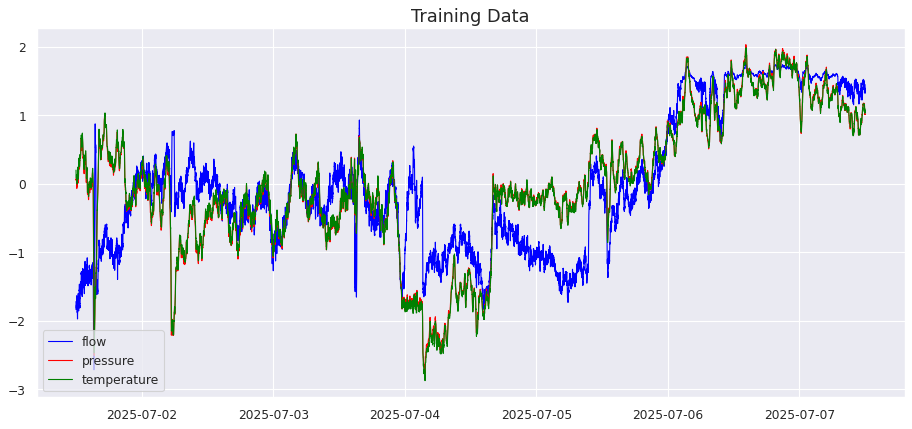

In [79]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot((data['YT.11FI_02044.PV'] - data['YT.11FI_02044.PV'].mean()) / data['YT.11FI_02044.PV'].std(), label='flow', color='blue', animated = True, linewidth=1)
ax.plot((data['YT.11PIC_02044.PV'] - data['YT.11PIC_02044.PV'].mean()) / data['YT.11PIC_02044.PV'].std(), label='pressure', color='red', animated = True, linewidth=1)
ax.plot((data['YT.11TI_02044.PV'] - data['YT.11TI_02044.PV'].mean()) / data['YT.11TI_02044.PV'].std(), label='temperature', color='green', animated = True, linewidth=1)
# ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [80]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft((train - train.mean())/train.std())
test_fft = np.fft.fft((test - test.mean())/test.std())

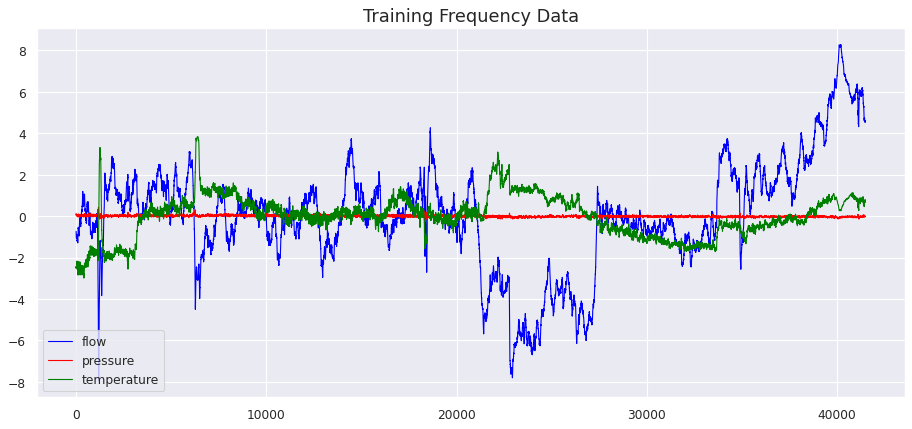

In [83]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='flow', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='pressure', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='temperature', color='green', animated = True, linewidth=1)
# ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Training Frequency Data', fontsize=16)
plt.show()

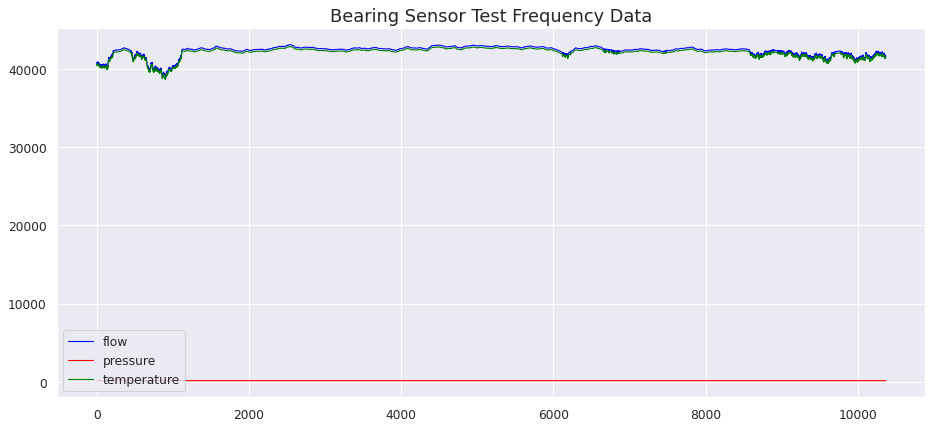

In [36]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='flow', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='pressure', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='temperature', color='green', animated = True, linewidth=1)
# ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [37]:
# normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
#scaler_filename = "scaler_data"
#joblib.dump(scaler, scaler_filename)

In [38]:
X_train

array([[-1.88016978,  0.49805446,  0.64949051],
       [-1.91662693,  0.50001023,  0.60423222],
       [-1.90085453,  0.49338044,  0.55659196],
       ...,
       [ 2.02438997,  1.29028542,  1.25207072],
       [ 2.02238576,  1.28999715,  1.25207072],
       [ 2.03621587,  1.28822722,  1.25207072]])

In [39]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (41472, 1, 3)
Test data shape: (10369, 1, 3)


In [40]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [41]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 32)             4608      
                                                                 
 lstm_9 (LSTM)               (None, 4)                 592       
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_11 (LSTM)              (None, 1, 32)             4736      
                                                           

In [42]:
# fit the model to the data
nb_epochs = 15
batch_size = 128
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.1).history

Epoch 1/15
292/292 [==============================] - 8s 11ms/step - loss: 0.5814 - val_loss: 0.4450
Epoch 2/15
292/292 [==============================] - 3s 9ms/step - loss: 0.3490 - val_loss: 0.4081
Epoch 3/15
292/292 [==============================] - 3s 9ms/step - loss: 0.1873 - val_loss: 0.3594
Epoch 4/15
292/292 [==============================] - 3s 9ms/step - loss: 0.0261 - val_loss: 0.1988
Epoch 5/15
292/292 [==============================] - 3s 9ms/step - loss: 0.0182 - val_loss: 0.1727
Epoch 6/15
292/292 [==============================] - 3s 9ms/step - loss: 0.0168 - val_loss: 0.1534
Epoch 7/15
292/292 [==============================] - 3s 9ms/step - loss: 0.0159 - val_loss: 0.1214
Epoch 8/15
292/292 [==============================] - 3s 9ms/step - loss: 0.0152 - val_loss: 0.1214
Epoch 9/15
292/292 [==============================] - 3s 9ms/step - loss: 0.0151 - val_loss: 0.1150
Epoch 10/15
292/292 [==============================] - 3s 9ms/step - loss: 0.0147 - val_loss: 0.115

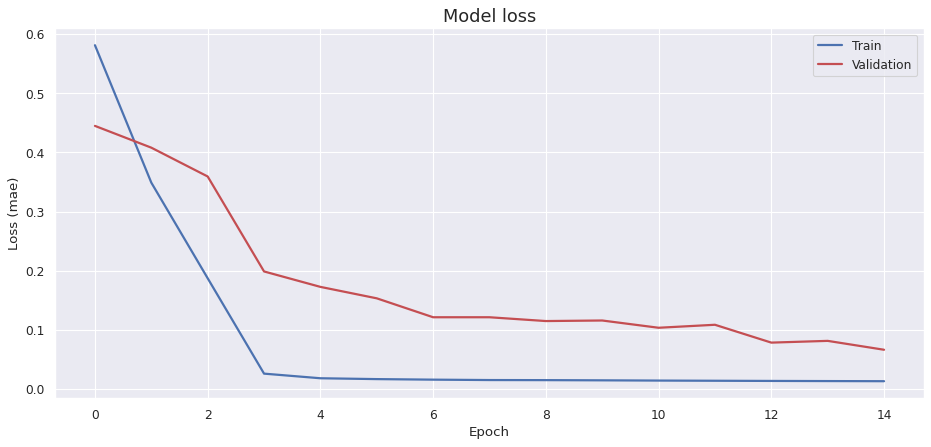

In [43]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

1296/1296 [==============================] - 4s 3ms/step


/home/sut-ai/anaconda3/envs/lstm-ad/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # This is added back by InteractiveShellApp.init_path()


(-0.1, 0.3)

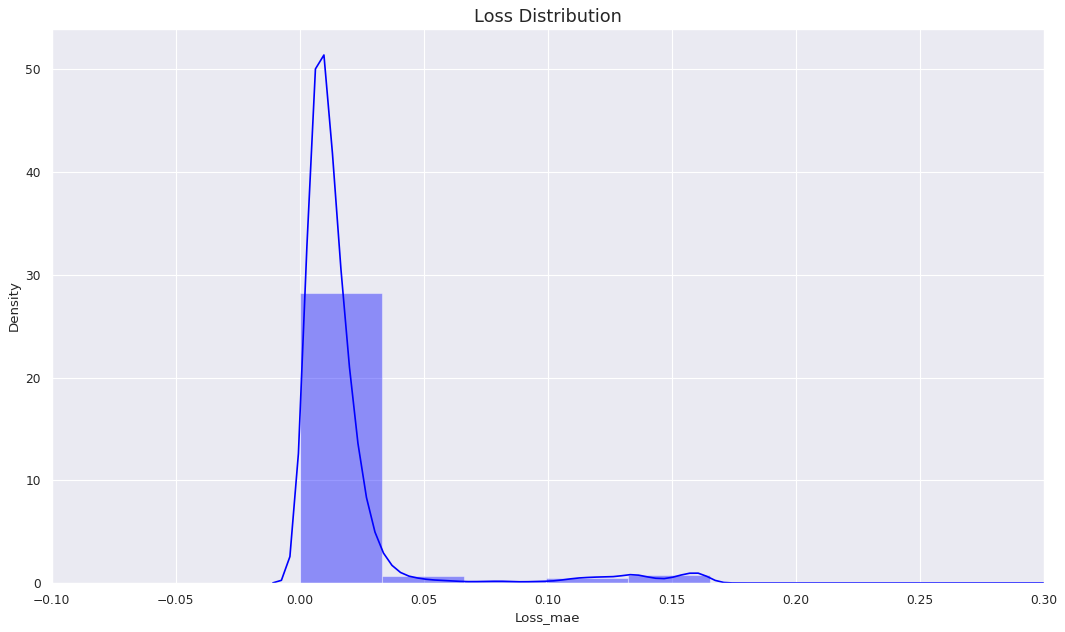

In [68]:
# plot the loss distribution of the training set
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns,index=train.index)

scored_train = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored_train['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([-0.1,.3])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [73]:
k = 3  
threshold = np.mean(scored_train['Loss_mae']) + k * np.std(scored_train['Loss_mae'])
print(f"Calculated Threshold: {threshold}")

Calculated Threshold: 0.11060971684825746


In [75]:
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

In [76]:
X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns, index=test.index)

scored_test = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test - Xtest), axis=1)

325/325 [==============================] - 1s 4ms/step


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:xlabel='timestamp'>

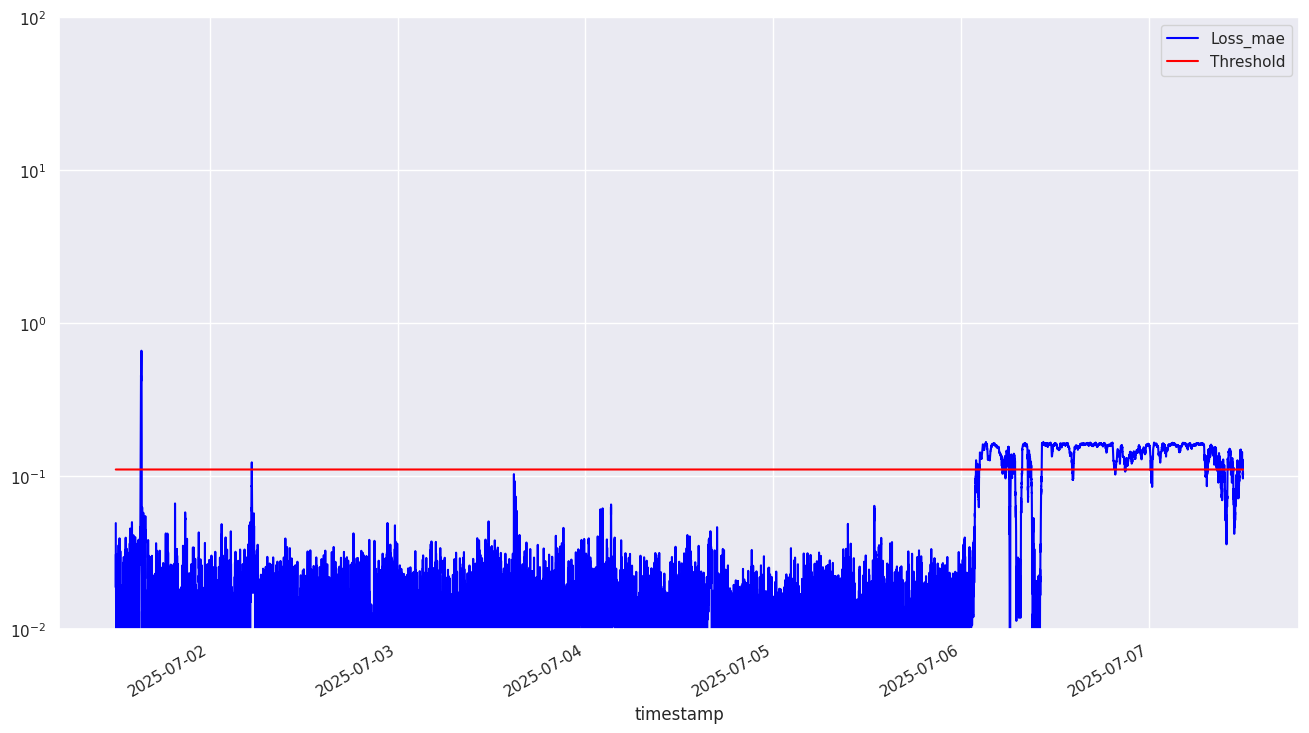

In [77]:
scored_test['Threshold'] = threshold
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']

scored_final = pd.concat([scored_train, scored_test])
scored_final.plot(logy=True, figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red','green'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [48]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
